In [2]:
!pip install yfinance


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------- ----------------------------- 0.8/3.0 MB 3.0 MB/s eta 0:00:01
     ------------------------ --------------- 1.8/3.0 MB 4.2 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 4.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 8.8 MB/s eta 0:00:00
  Created wheel for multitasking: filename=mult

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [3]:
import yfinance as yf

df = yf.download('BTC-USD', start='2023-01-01', end='2025-11-27', interval='1d')
print(df.head())

df.to_csv('BTC-USD_historical.csv')


C:\Users\Mohammed\AppData\Local\Temp\ipykernel_1624\3474652412.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2023-01-01', end='2025-11-27', interval='1d')
[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2023-01-01  16625.080078  16630.439453  16521.234375  16547.914062   
2023-01-02  16688.470703  16759.343750  16572.228516  16625.509766   
2023-01-03  16679.857422  16760.447266  16622.371094  16688.847656   
2023-01-04  16863.238281  16964.585938  16667.763672  16680.205078   
2023-01-05  16836.736328  16884.021484  16790.283203  16863.472656   

Price            Volume  
Ticker          BTC-USD  
Date                     
2023-01-01   9244361700  
2023-01-02  12097775227  
2023-01-03  13903079207  
2023-01-04  18421743322  
2023-01-05  13692758566  


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler




In [5]:
data = df[['Close']]


data = data.dropna()
data.head()


Price,Close
Ticker,BTC-USD
Date,
2023-01-01,16625.080078
2023-01-02,16688.470703
2023-01-03,16679.857422
2023-01-04,16863.238281
2023-01-05,16836.736328


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [8]:
X = []
y = []

window_size = 60

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# إعادة تشكيل X للـ LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X.shape, y.shape


((1001, 60, 1), (1001,))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

# Layer 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))

# Layer 2
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Layer 3
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# Layer4 
model.add(Dense(1))  # نتوقع قيمة واحدة (سعر اليوم القادم)

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


C:\Users\Mohammed\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X, y,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.0519 - val_loss: 0.0074
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0058 - val_loss: 0.0077
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0045 - val_loss: 0.0111
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0046 - val_loss: 0.0107
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0037 - val_loss: 0.0054
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0032 - val_loss: 0.0059
Epoch 12/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0

In [11]:
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size - 60:]


In [12]:
X_test = []
y_test = scaled_data[training_size:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [13]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)   


actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


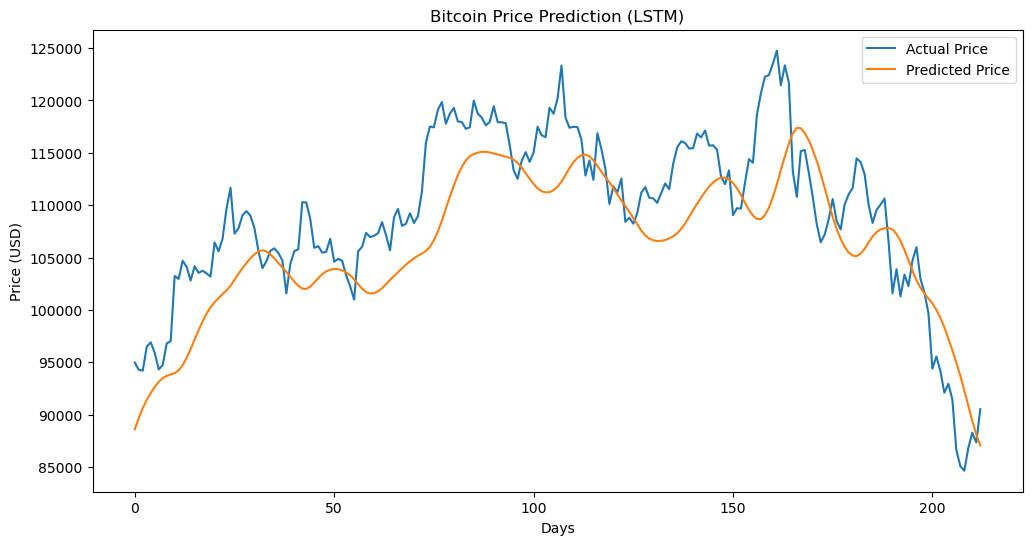

In [14]:
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.title("Bitcoin Price Prediction (LSTM)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [15]:
last_60 = scaled_data[-60:]
future_input = last_60.reshape(1, 60, 1)


In [16]:
future_predictions = []

for _ in range(30):
    pred = model.predict(future_input)[0][0]
    future_predictions.append(pred)

     
    new_input = np.append(future_input[0][1:], pred)
    future_input = new_input.reshape(1, 60, 1)


future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

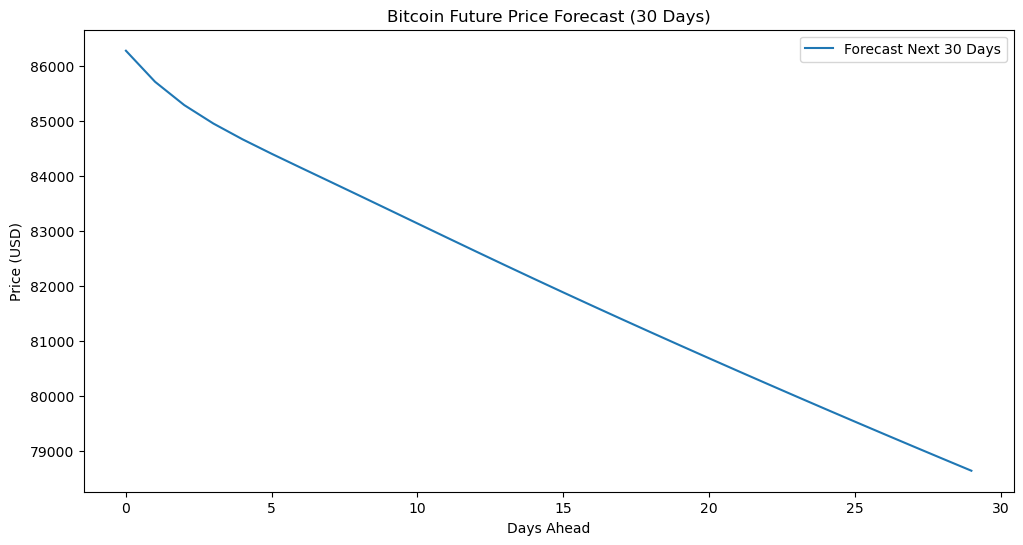

In [17]:
plt.figure(figsize=(12,6))
plt.plot(future_predictions, label="Forecast Next 30 Days")
plt.title("Bitcoin Future Price Forecast (30 Days)")
plt.xlabel("Days Ahead")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_prices, predictions)
mse = mean_squared_error(actual_prices, predictions)

print("MAE:", mae)
print("MSE:", mse)


MAE: 4388.813050176057
MSE: 28006830.50366928
